In [1]:
#################################################################
# Author: Astrid Alsema
# Date: Oct 2021
# Dataset: pseudobulked Visium Spatial Transcriptomics for MS lesions
# Purpose: create a PCA plot using the DESeq2::vst variance stabilizing transformed counts

# Required inputs:
# - Countfile_WM.csv : containing count table with pseudobulk samples 
# - WM_Targetfile_2023.csv: csv file with information about samples
# Output: pdf with PCA plot "PCA_WMsamples_PLWM.pdf"
#################################################################

In [1]:
rm(list = ls())

################ load libraries #####################################
library(vsn)
library(plyr)
library(dplyr)
library(DESeq2)
library(stringr)
require(ggplot2)
require(ggrepel)
require(RColorBrewer)
setwd("<your_indir>")

Loading required package: Biobase

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, setdiff, sort,
    table, tapply, union, unique, unsplit, which.max, which.min


Welcome to Bioconductor

    Vignettes contain introductory material; view with
    'browseVignettes()'. To cite Bioconductor, see
    'citation("Biobase")', and for packages 'citation("pkgname")'.



Attaching package: ‘dplyr’


The following objects are masked from ‘package:plyr’:

    arrange, count, desc, failwith, id, mutate, rename, summ

In [2]:
# load counts
countfile <- read.csv(file = "Routput/pseudobulk/Countfile_WM.csv", sep=",", row.names = 1)
# create coldata
target <- read.csv(file = "Routput/pseudobulk/WM_Targetfile_2023.csv", sep=",", header = T, 
                   stringsAsFactors = F, row.names = 1)
head(target)

,Sample_ID,Group,Slide_ID,donor_ID,Age,Seks,RIN,CSF_pH,PMD,PMD_min
,<chr>,<chr>,<int>,<chr>,<int>,<chr>,<dbl>,<dbl>,<dbl>,<int>
ST31_CWM,ST31,CWM,1,2012-070,79,M,7.7,6.38,5.45,345
ST32_CWM,ST32,CWM,1,2012-088,85,F,7.2,6.60,6.25,385
ST33_PL_active,ST33,PL_Active,1,2011-077,66,F,8.6,6.45,9.35,575
ST33_RIM_active,ST33,RIM_Active,1,2011-077,66,F,8.6,6.45,9.35,575
ST33_active,ST33,Active,1,2011-077,66,F,8.6,6.45,9.35,575
ST69_PL_active,ST69,PL_Active,10,2015-064,50,M,8.7,6.55,10.50,650


In [3]:
# PCA2,
# remove some unused samples
to_drop <- c("ST34_low_nr_counts", "ST37_low_nr_counts", "ST71_GM", "ST73_GM", "ST79_GM")
countfile <- countfile[, !colnames(countfile) %in% to_drop]

# check
ncol(countfile)
nrow(target)
# reorder the target file
target <- target[match(colnames(countfile), rownames(target)) ,]

#should be true
identical(colnames(countfile), rownames(target) )

[1] 35

[1] 35

[1] TRUE

In [4]:
# subset including the CWM, NAWM,perilesional groups 
to_keep <- rownames(target)[target$Group %in% c("CWM", "NAWM", "PL_Active", "PL_act.inact")]
print("these samples will be included for PCA:")
print(to_keep)
target.1 <- target[row.names(target) %in% to_keep , ]
target.1 <- droplevels(target.1)
countfile.1 <- countfile[colnames(countfile) %in% to_keep]
# sanity dimension check
identical(nrow(target.1), ncol(countfile.1))

[1] "these samples will be included for PCA:"
 [1] "ST31_CWM"        "ST32_CWM"        "ST33_PL_active"  "ST34_NAWM"      
 [5] "ST37_NAWM"       "ST38_NAWM"       "ST67_PL_chronic" "ST68_PL_chronic"
 [9] "ST69_PL_active"  "ST70_PL_active"  "ST71_PL_chronic" "ST72_PL_chronic"
[13] "ST73_PL_chronic" "ST74_PL_chronic" "ST79_PL_active" 


[1] TRUE

In [5]:
###################################################################################################

# make DESEQ2 object
dds0 <- DESeqDataSetFromMatrix(countData = as.matrix(countfile.1),
                               colData = target.1,
                               design = ~ Group)
dds0$Group <- relevel( dds0$Group, "CWM" ) # set the reference group

# # pre-filtering, remove genes with less than 2 reads. Relevant for PCA. many zero counts still in ST data (compared to regular bulk),
keep <- rowSums(counts(dds0)) >= 2 #
dds <- dds0[keep,]
# many genes will be removed, since there are still many zero counts in this data.
print(paste("we prefiltered out", nrow(dds0) - nrow(dds), "lowly expressed genes"))
print(paste("we keep", nrow(dds), "genes for PCA"))



Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”


[1] "we prefiltered out 11128 lowly expressed genes"
[1] "we keep 22410 genes for PCA"


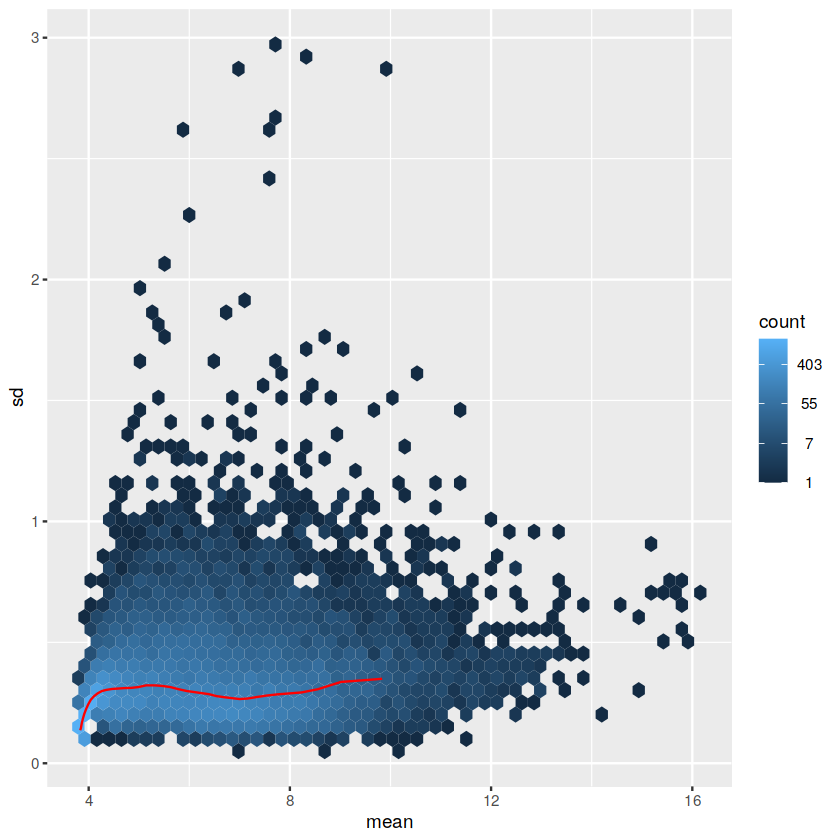

In [6]:
########################################## Normalize for PCA #########################################################
vsd <- vst(dds, blind = FALSE, fitType = "parametric") # variance stabilizing tranformation, similar to SCtransform
meanSdPlot(assay(vsd), ranks = FALSE) # vsd make the most straight line, also for medium abundance genes. compared to rlog


In [7]:
########################################## compute PCs #########################################################
# # calculate size Factor to correct library size in DE analysis
dds <- estimateSizeFactors(dds, type = "ratio") # median ratio method, because Stahl et al used this for mouse olfactory pseudobulk, ST kit.

# use vsd counts for pca
transformed.counts <- as.matrix(assay(vsd))
# PCA
ntop = 500
rv <- rowVars(transformed.counts)
select <- order(rv, decreasing = TRUE)[seq_len(min(ntop, length(rv)))]
pca <- prcomp(t(transformed.counts[select, ]))
percentVar <- pca$sdev^2/sum(pca$sdev^2)

Warning message:
“useNames = NA is deprecated. Instead, specify either useNames = TRUE or useNames = FALSE.”


In [10]:
########################################## data frame for plot #########################################################
# define the colors
group_cols <- c("#80C280", "#B36F9F",  "#FF4D4D", "#FFB55E")
# define the legend order
group <- factor(dds$Group, levels = c("CWM", "NAWM",  "PL_Active", "PL_act.inact"))
sample_ID <- factor(dds$Sample_ID) 
sex <-factor(dds$Seks,levels=c("F","M"))

d <- data.frame(PC1 = pca$x[, 1], PC2 = pca$x[, 2], group = group, donor = sample_ID) #

Warning message:
“`aes_string()` was deprecated in ggplot2 3.0.0.
ℹ Please use tidy evaluation idioms with `aes()`.
ℹ See also `vignette("ggplot2-in-packages")` for more information.”


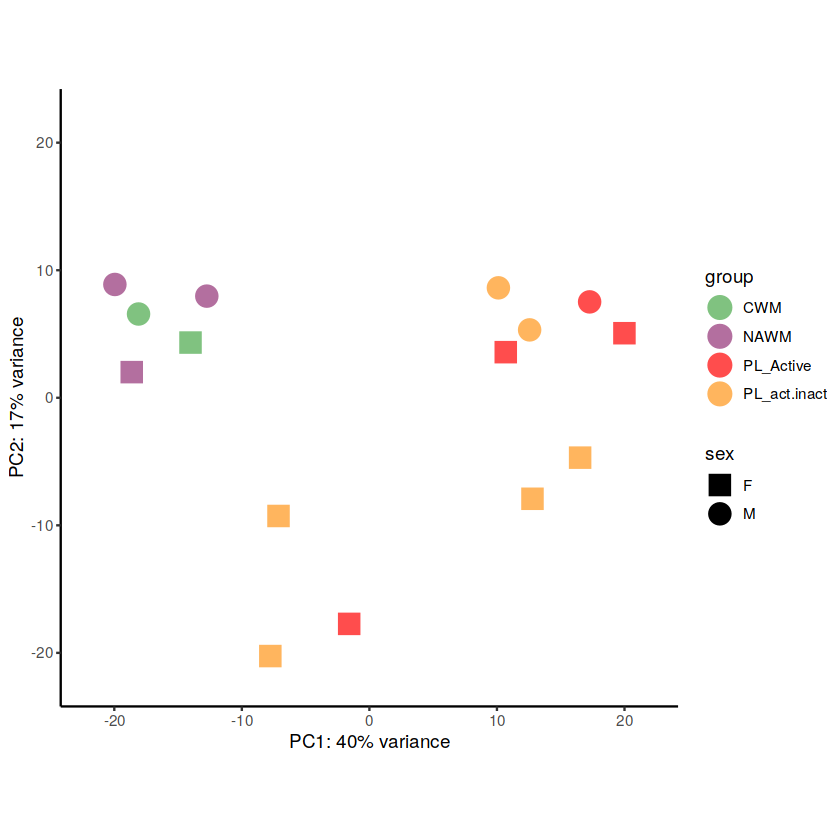

In [11]:
########################################## plot #########################################################
pdf("Routput/pseudobulk_PCA/PCA_WMsamples_PLWM.pdf", width=10, height = 10)
ggplot(data = d, aes_string(x = "PC1", y = "PC2", color = "group",shape="sex")) +
  geom_point(aes(), size = 6, alpha = 1) +
  xlab(paste0("PC1: ", round(percentVar[1] * 100), "% variance")) +
  ylab(paste0("PC2: ", round(percentVar[2] * 100), "% variance")) +

  scale_x_continuous(breaks = c(-20, -10, 0, 10, 20), limits = c(-22, 22)) +
  scale_y_continuous(breaks = c(-20, -10, 0, 10, 20), limits = c(-22, 22)) +
  theme_classic() +
  scale_color_manual(values = group_cols) + # choose cols 
  scale_shape_manual(values = seq(15,19)) +
  theme(aspect.ratio = 1) 
dev.off()



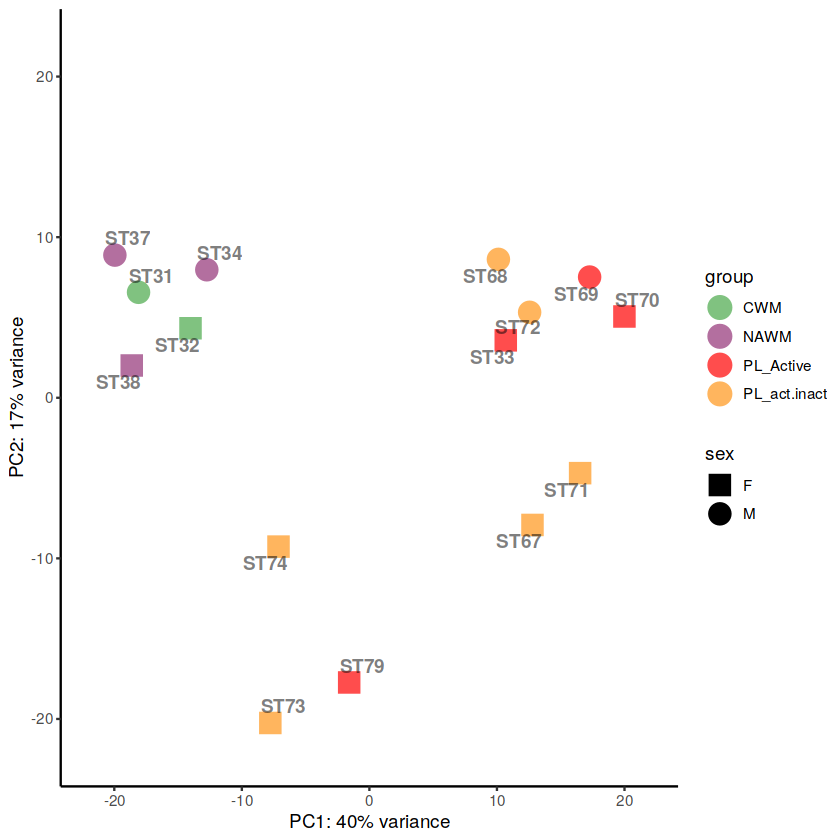

In [14]:
########################################## optional plot #########################################################
# pdf("Routput/pseudobulk_PCA/PCA_2_PLWM_samplelabel.pdf", width=10, height = 10)
ggplot(data = d, aes_string(x = "PC1", y = "PC2", color = "group",shape="sex")) +
  geom_point(aes(), size = 6, alpha = 1) +
  xlab(paste0("PC1: ", round(percentVar[1] * 100), "% variance")) +
  ylab(paste0("PC2: ", round(percentVar[2] * 100), "% variance")) +

  scale_x_continuous(breaks = c(-20, -10, 0, 10, 20), limits = c(-22, 22)) +
  scale_y_continuous(breaks = c(-20, -10, 0, 10, 20), limits = c(-22, 22)) +
  scale_color_manual(values = group_cols) + #choose cols
  scale_shape_manual(values = seq(15,19)) +
  theme(aspect.ratio = 1) + 
  theme_classic() +
# Optional: Add sample identifiers as label
  geom_text_repel(aes(label=as.character(donor)), color="black",
                                  fontface="bold",
                                  box.padding = unit(0.3, "lines"),
                                  point.padding = unit(0.5, "lines"),
                                  segment.colour = "grey50", alpha = 0.5)
# dev.off()

In [13]:
sessionInfo()

R version 4.2.0 (2022-04-22)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Ubuntu 20.04.5 LTS

Matrix products: default
BLAS/LAPACK: /data/bcn/p283607/anaconda3/envs/R4.2/lib/libopenblasp-r0.3.21.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats4    stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] RColorBrewer_1.1-3          ggrepel_0.9.4              
 [3] ggplot2_3.4.4               stringr_1.5.1              
 [5] DESeq2_1.38.3               SummarizedExperiment_1.28.0
 [7] MatrixGenerics_1.10.0       matrixStats_1.1.0          
 [9] GenomicRanges_1.50.2        GenomeInfoD